In [1]:
!date

Wed Mar  4 01:29:24 PST 2020


# Isoform atlas

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [209]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

cluster_order = [
    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
    "VLMC",
    "Endo",
    "Astro",
    "SMC"
]

In [210]:
gene = anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("../cell_ranger_annotation/isoform.h5ad")

In [211]:
markers = pd.read_csv("tables/subclass_DE_isoform_only.csv", index_col=0)

## We remove ATP synthase isoforms as well as lincRNA , as they are not relevant to the analysis. 

In [213]:
markers = markers[np.logical_and(~markers["transcript_name"].str.contains("Atp"), ~markers["transcript_name"].str.contains("AC130815.2"))]

In [214]:
features = isoform.var.transcript_name.values

In [215]:
mtx = isoform.layers["norm"].todense()
markers["exp"] = markers.transcript_name.apply(lambda x: mtx[:,isoform.var.transcript_name==x].mean())

In [216]:
# markers.iloc[markers.groupby("index")["exp"].apply(np.argmax)]

In [217]:
def pick_top(l):
    idx = [np.where(features==i)[0][0] for i in l]

    argmax = np.argmax(nd(isoform.layers["norm"].mean(axis=0))[idx])
    return argmax

In [225]:
%%time
top = markers.groupby("index")['transcript_name'].apply(lambda x: list(x)[0:10][pick_top(list(x)[0:10])])

CPU times: user 15.2 s, sys: 11.4 s, total: 26.6 s
Wall time: 26.6 s


In [226]:
top

index
Astro             Mc1r-201_ENSMUST00000098324
Endo           Pglyrp1-201_ENSMUST00000032573
L2/3 IT         S100a6-201_ENSMUST00000001051
L5 IT            Dkkl1-201_ENSMUST00000033057
L5 PT            Tekt5-201_ENSMUST00000043415
L5/6 NP        Tmem159-201_ENSMUST00000033210
L6 CT             Ighm-201_ENSMUST00000103426
L6 IT             Blnk-202_ENSMUST00000117695
L6 IT Car3       Cpne4-204_ENSMUST00000157006
L6b               Ctgf-201_ENSMUST00000020171
Lamp5            Cplx3-203_ENSMUST00000217015
Low Quality      Cbln4-201_ENSMUST00000087950
Pvalb            Pvalb-201_ENSMUST00000005860
SMC               Myl9-201_ENSMUST00000088552
Sncg            Cxcl14-201_ENSMUST00000021970
Sst                Sst-201_ENSMUST00000004480
VLMC              Apoe-201_ENSMUST00000003066
Vip                Vip-201_ENSMUST00000019906
Name: transcript_name, dtype: object

In [227]:
top = top.drop("Low Quality")
top = top[cluster_order]
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in top]
top_name = ["".join(i.split("_")[:-1]) for i in top]

In [228]:
top

index
L5 IT           Dkkl1-201_ENSMUST00000033057
L5/6 NP       Tmem159-201_ENSMUST00000033210
L5 PT           Tekt5-201_ENSMUST00000043415
L2/3 IT        S100a6-201_ENSMUST00000001051
L6b              Ctgf-201_ENSMUST00000020171
L6 IT            Blnk-202_ENSMUST00000117695
L6 CT            Ighm-201_ENSMUST00000103426
L6 IT Car3      Cpne4-204_ENSMUST00000157006
Lamp5           Cplx3-203_ENSMUST00000217015
Sncg           Cxcl14-201_ENSMUST00000021970
Vip               Vip-201_ENSMUST00000019906
Sst               Sst-201_ENSMUST00000004480
Pvalb           Pvalb-201_ENSMUST00000005860
VLMC             Apoe-201_ENSMUST00000003066
Endo          Pglyrp1-201_ENSMUST00000032573
Astro            Mc1r-201_ENSMUST00000098324
SMC              Myl9-201_ENSMUST00000088552
Name: transcript_name, dtype: object

In [229]:
mat = isoform.layers["norm"].todense()
obs = isoform.obs
var = isoform.var

In [239]:
markers[markers.transcript_name.str.contains("Car")]

,index,transcript_name,p_raw,p_bonferroni,exp
167,L2/3 IT,Car4-201_ENSMUST00000103194,6.065927e-79,2.097961e-74,82.342521
236,L2/3 IT,Car11-204_ENSMUST00000210872,5.115572e-35,1.769272e-30,15.256051
2146,Pvalb,Carf-210_ENSMUST00000191232,1.307373e-23,4.521679e-19,2.857920


In [299]:
marker_map = {"L5 IT": "Dkkl1-201_ENSMUST00000033057",
"L5/6 NP": "Il11ra1-204_ENSMUST00000108042",
"L5 PT": "S100b-201_ENSMUST00000036387",
"L2/3 IT": "Calb1-201_ENSMUST00000029876",    
"L6b": "Glra2-201_ENSMUST00000058787",
"L6 IT": "Cdh9-202_ENSMUST00000228307",
"L6 CT": "Cpa6-203_ENSMUST00000147575",
"L6 IT Car3": "Cpne4-204_ENSMUST00000157006",
"Lamp5": "Lamp5-202_ENSMUST00000123436",
"Sncg": "Cnr1-202_ENSMUST00000084736",
"Vip": "Vip-201_ENSMUST00000019906",
"Sst": "Sst-201_ENSMUST00000004480",
"Pvalb": "Pvalb-201_ENSMUST00000005860",
"VLMC": "Myl12a-201_ENSMUST00000024846",
"Endo": "Pglyrp1-201_ENSMUST00000032573",
"Astro": "Mc1r-201_ENSMUST00000098324",
"SMC":  "Myl9-201_ENSMUST00000088552"}

In [300]:
top_idx = [np.where(isoform.var.transcript_name == i)[0][0] for i in list(marker_map.values())]
top_name = ["".join(i.split("_")[:-1]) for i in list(marker_map.values())]

In [301]:
top

index
L5 IT           Dkkl1-201_ENSMUST00000033057
L5/6 NP       Tmem159-201_ENSMUST00000033210
L5 PT           Tekt5-201_ENSMUST00000043415
L2/3 IT        S100a6-201_ENSMUST00000001051
L6b              Ctgf-201_ENSMUST00000020171
L6 IT            Blnk-202_ENSMUST00000117695
L6 CT            Ighm-201_ENSMUST00000103426
L6 IT Car3      Cpne4-204_ENSMUST00000157006
Lamp5           Cplx3-203_ENSMUST00000217015
Sncg           Cxcl14-201_ENSMUST00000021970
Vip               Vip-201_ENSMUST00000019906
Sst               Sst-201_ENSMUST00000004480
Pvalb           Pvalb-201_ENSMUST00000005860
VLMC             Apoe-201_ENSMUST00000003066
Endo          Pglyrp1-201_ENSMUST00000032573
Astro            Mc1r-201_ENSMUST00000098324
SMC              Myl9-201_ENSMUST00000088552
Name: transcript_name, dtype: object

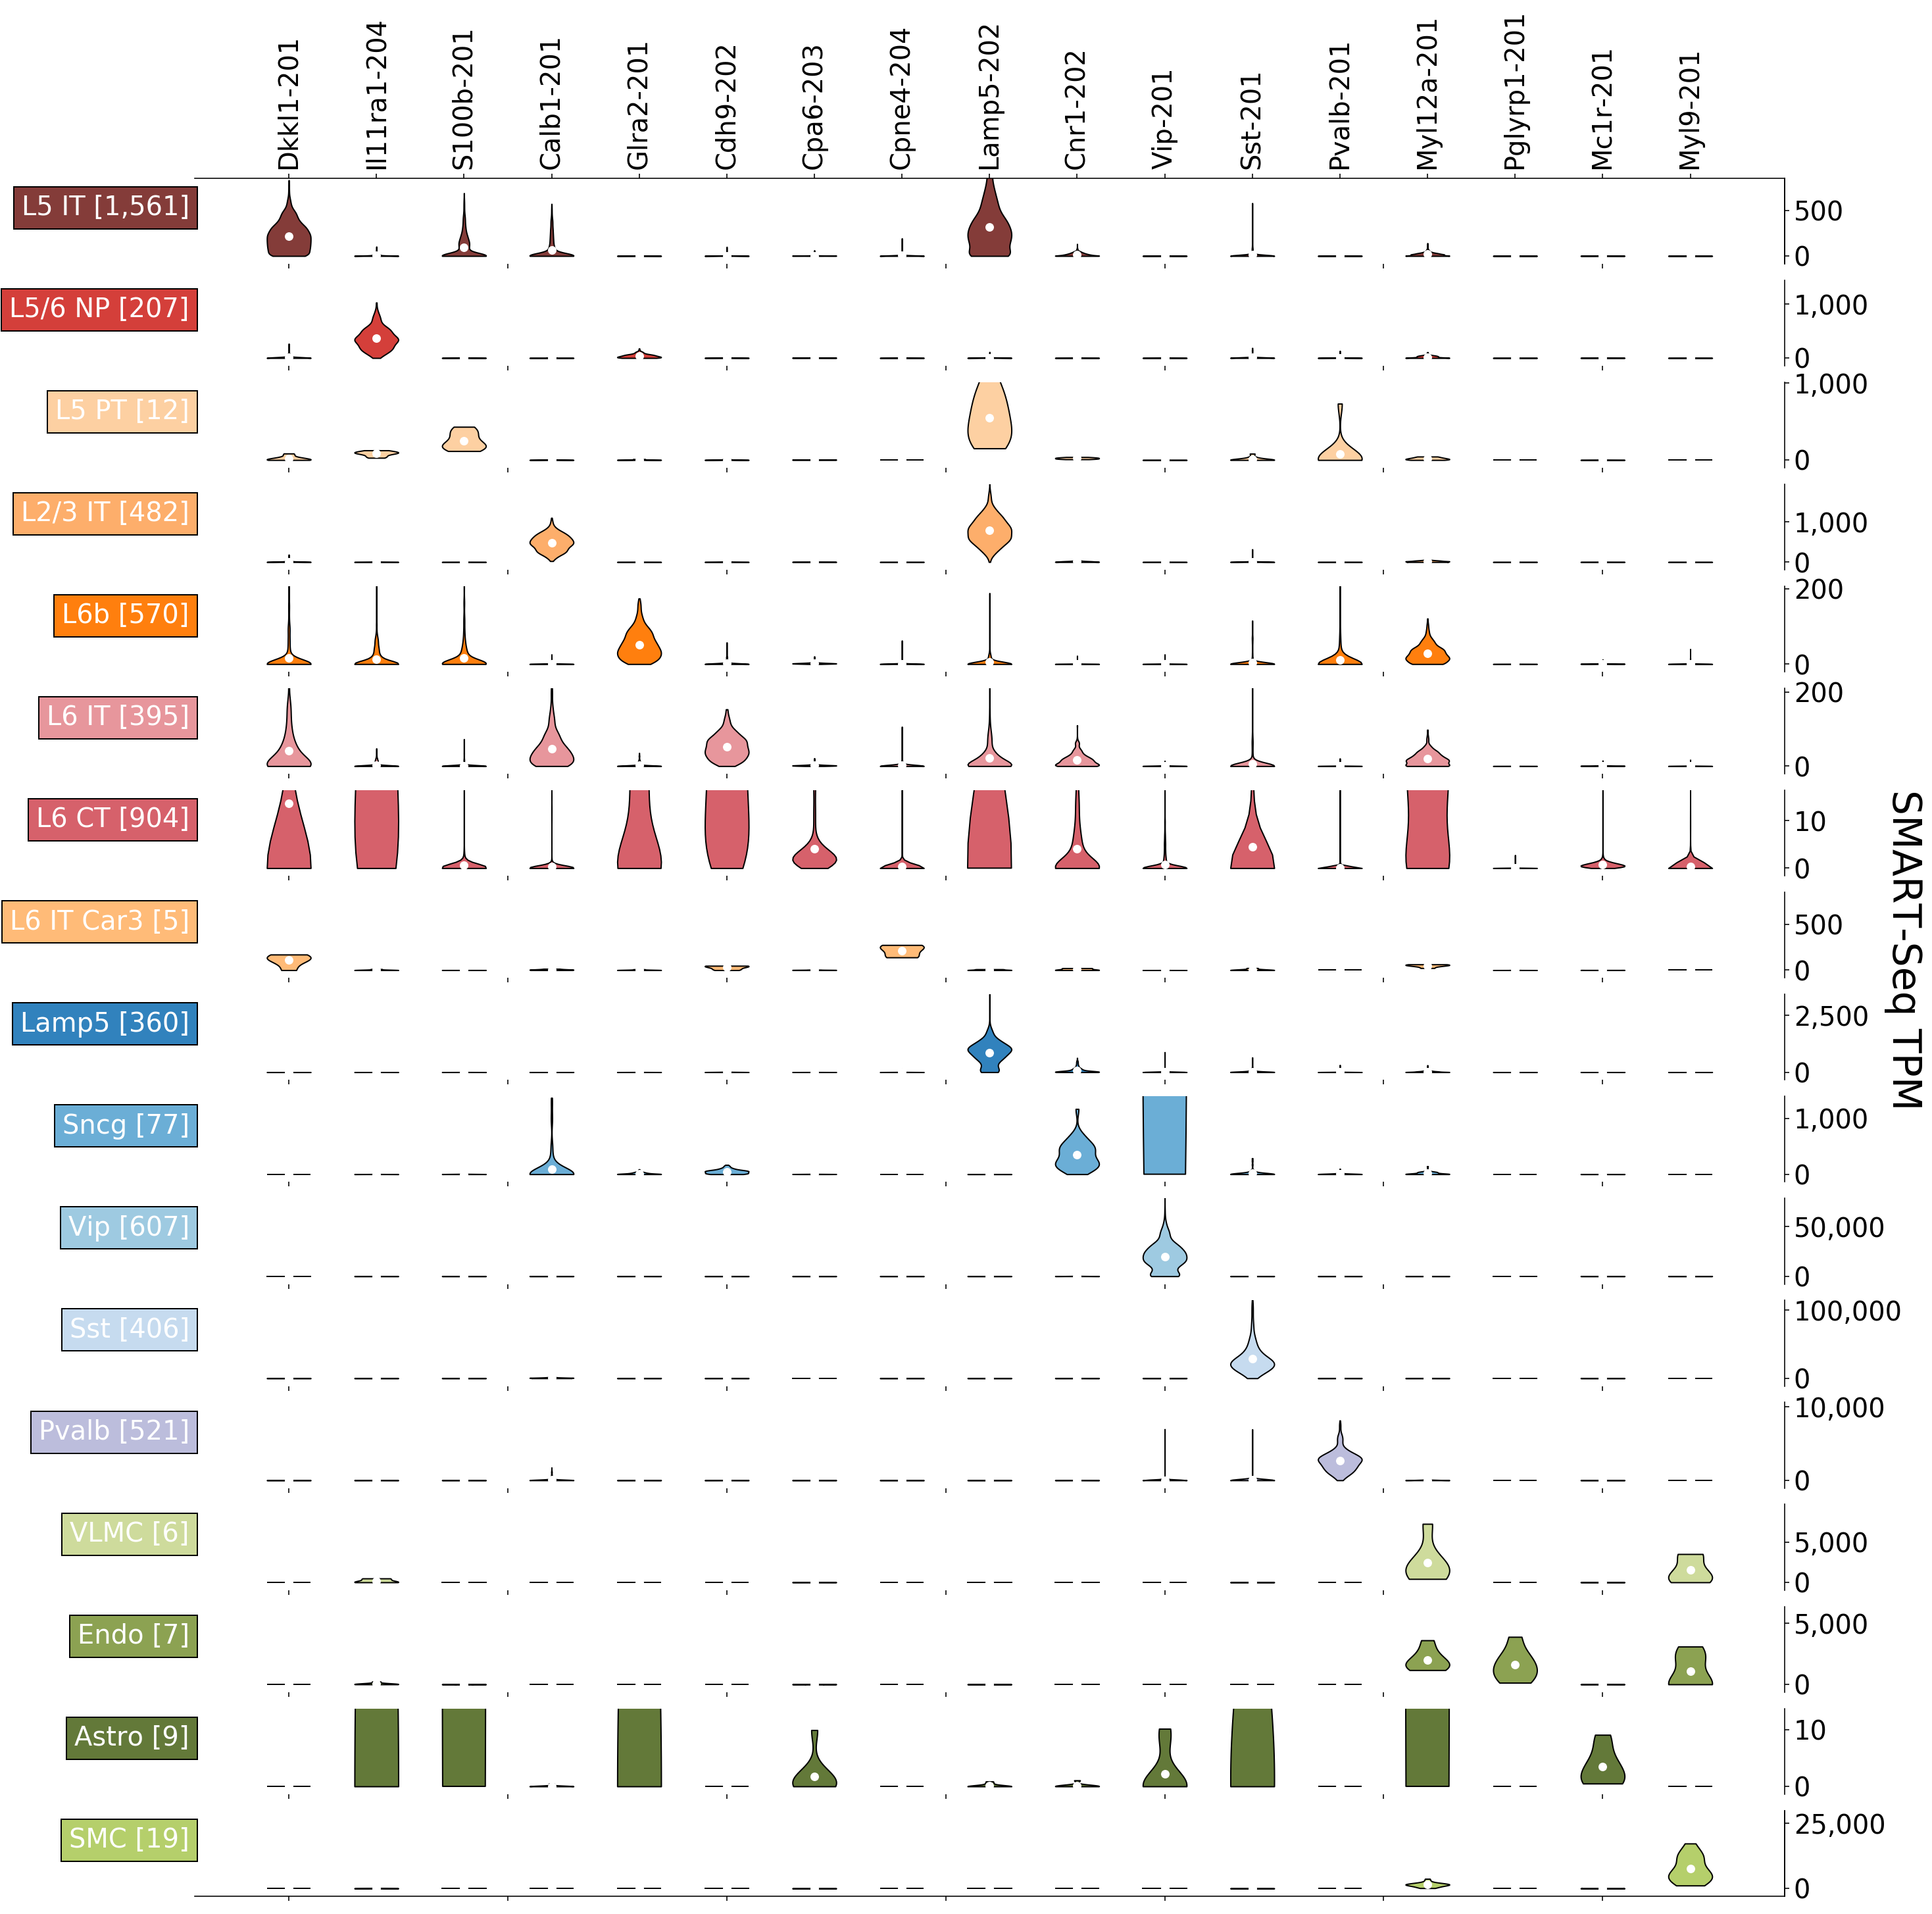

In [333]:
# unique = np.unique(gene.obs.subclass_label)
# unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.array(cluster_order)

fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = top_name
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.subclass_label==c,:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_facecolor(cluster_cmap[c])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        #pc.set_facecolor('#D43F3A')
        

    means = [np.mean(i) for i in x.T]
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=3)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cluster_cmap[c]))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'SMART-Seq TPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.savefig("./figures/isoform_atlas_ignore_gene.png", bbox_inches='tight', dpi=300)
plt.show()